In [1]:
# environment setup
from matplotlib import pyplot as plt
import pandas as pd
from openbabel import openbabel as ob
from scipy.stats import norm, linregress
import numpy as np
import sys; sys.path.append("/home/shachar/repos/miscellaneous/CodStructures/")
import utils
from featurizers import StructurePropertyFeaturizer
from read_to_sql import StructureProperty, Substituent
# creating session with SQL database
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
engine = create_engine("sqlite:///{}".format("/home/shachar/repos/miscellaneous/CodStructures/main.db"))
session = sessionmaker(bind=engine)()
utils.define_pallet()

In [2]:
# setting up important global variables & functions

def non_planarity_modes(session):
    names = session.query(StructureProperty.property).distinct().all()
    return [x[0] for x in names if "non planarity" in x[0]]

def homa_properties(session, target="homa"):
    names = session.query(StructureProperty.property).filter(StructureProperty.source == "homa").distinct().all()
    return [x[0] for x in names if target in x[0]]

def homa_values_df(session, sids, target, avg_pyrroles):
    # reading the data from SQL
    homa_props = homa_properties(session, target=target)
    homa_df = StructurePropertyFeaturizer(session, sids, homa_props, property_units=None)
    homa_df.columns = [c.split()[0] for c in homa_df.columns]
    if avg_pyrroles:
        # adding column of average pyrrole HOMA score
        pyrrole_cols = [c for c in homa_df.columns if "pyrrole" in c]
        homa_df["pyrrole"] = homa_df[pyrrole_cols].mean(axis=1)
        # removing all other pyrrole columns
        homa_df = homa_df[[c for c in homa_df.columns if not c in pyrrole_cols]]
    return homa_df

def non_planarity_df(session, sids, units, add_total_non_planarity):
    # reading the data
    modes = non_planarity_modes(session)
    # removing wavingy2 mode as it exists only in corroles
    modes.remove("wavingy2 non planarity")
    mode_units = [units for _ in range(len(modes))]
    if add_total_non_planarity:
        modes.append("total out of plane (exp)")
        mode_units.append("A")
    non_planarity_df = StructurePropertyFeaturizer(session, sids, modes, mode_units).to_dataframe()
    non_planarity_df.columns = [c.split()[0] for c in non_planarity_df.columns]
    return non_planarity_df

def scatter_plot(x, y, ax=None, xname=None, yname=None, add_fitted_line=False, add_ideal_line=False, label=None):
    if ax is None:
        ax = plt.gca()
    ax.scatter(x, y, label=label)
    if xname is not None:
        ax.set_xlabel(xname)
    if yname is not None:
        ax.set_ylabel(yname)
    if add_fitted_line:
        a, b = np.polyfit(x, y, deg=1)
        fitted_x = [min(x), max(x)]
        fitted_y = [a * v + b for v in fitted_x]
        ax.plot(fitted_x, fitted_y, "r--")
    if add_ideal_line:
        fitted_x = [min(x), max(x)]
        ax.plot(fitted_x, fitted_x, "r--")

def p_value(sample_data, population_data):
    """Calculate the p-value of sample from normal distribution. calculates the probability that the mean difference between the sample and the population is at least as large as measured."""
    sample_mean = np.mean(sample_data)
    population_mean = np.mean(population_data)
    population_std = np.std(population_data)
    N = len(sample_data)
    statistic = abs((sample_mean - population_mean) / (population_std / np.sqrt(N)))
    return 2 * norm(0, 1).sf(statistic)

def metal_radius(session, sid: int):
    """Get the VDW radius of the metal center"""
    metal = session.query(Substituent.substituent).filter(Substituent.structure == sid).filter(Substituent.position == "metal").all()[0][0]
    metal = utils.mol_from_smiles(metal).GetAtom(1)
    return [ob.GetVdwRad(metal.GetAtomicNum())]


# Basic analysis

In [3]:
# deciding the type of structures to analyze
sids = utils.sids_by_type(session, "all")

In [4]:
por_sids = utils.sids_by_type(session, "porphyrin")
cor_sids = utils.sids_by_type(session, "corrole")
cor_homa = homa_values_df(session, cor_sids, "homa", True)
cor_en = homa_values_df(session, cor_sids, "en", True)
cor_geo = homa_values_df(session, cor_sids, "geo", True)
por_homa = homa_values_df(session, por_sids, "homa", True)
por_en = homa_values_df(session, por_sids, "en", True)
por_geo = homa_values_df(session, por_sids, "geo", True)

TypeError: StructurePropertyFeaturizer.__init__() got multiple values for argument 'property_units'

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


NameError: name 'por_homa' is not defined

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

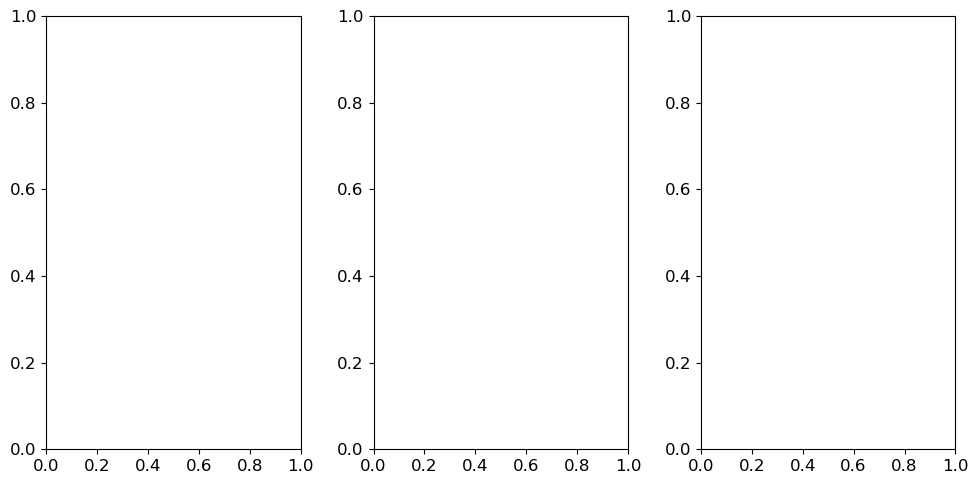

In [5]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5))
fig.tight_layout()
for i, c in enumerate(por_homa.columns):
    axs[i].hist(por_homa[c], density=True, alpha=0.7, label="porphyrins")
    axs[i].hist(cor_homa[c], density=True, alpha=0.7, label="corroles")
    axs[i].set_title(" ".join(c.split("_")).title())
    axs[i].legend()

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))
fig.tight_layout()
for i, c in enumerate(por_homa.columns):
    axs[0, i].hist(por_en[c], density=True, alpha=0.7, label="porphyrins")
    axs[0, i].hist(cor_en[c], density=True, alpha=0.7, label="corroles")
    axs[0, i].set_title(" ".join(c.split("_")).title())
    axs[0, i].legend()
    axs[1, i].hist(por_geo[c], density=True, alpha=0.7, label="porphyrins")
    axs[1, i].hist(cor_geo[c], density=True, alpha=0.7, label="corroles")
    axs[1, i].legend()
axs[0, 0].set_ylabel("EN")
axs[1, 0].set_ylabel("GEO")

## HOMA
Showing key statistics and analyzing the HOMA properties. HOMA consists of: pyrrole (1 to 4) score, inner ring score and outer ring score. Inner and out ring scores can be used as is, while the pyrrole scores are averaged

In [423]:
# reading the data
homa_df = homa_values_df(session, sids, "homa", True)
en_df = homa_values_df(session, sids, "en", True)
geo_df = homa_values_df(session, sids, "geo", True)

In [ ]:
# scatter plots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14, 7))
fig.tight_layout()
for i, c in enumerate(homa_df.columns):
    scatter_plot(homa_df[c], en_df[c], ax=axs[0, i], add_fitted_line=True)
    scatter_plot(homa_df[c], geo_df[c], ax=axs[1, i], add_fitted_line=True)
    axs[0, i].set_title(" ".join(c.split("_")).title())
    axs[1, i].set_xlabel("HOMA")
axs[0, 0].set_ylabel("EN")
axs[1, 0].set_ylabel("GEO")

## Non-Planarity

In [9]:
absolute_np = non_planarity_df(session, sids, "A", add_total_non_planarity=False)
relative_np = non_planarity_df(session, sids, "%", add_total_non_planarity=True)

In [21]:
relative_np.describe()

,doming,saddling,ruffling,wavingx,wavingy,propellering,doming2,saddling2,ruffling2,wavingx2,propellering2,total
count,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000
mean,12.577541,26.188418,18.195675,10.364771,8.578725,1.072165,7.074337,4.008179,2.862045,6.503505,1.562170,0.827577
std,13.973740,23.590289,21.011408,14.545347,11.670849,1.443447,6.876637,4.146813,2.752324,10.452066,2.719005,0.832264
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.894912,3.333920,1.744726,1.598655,1.516364,0.075367,1.924317,0.619784,0.891453,0.846179,0.310113,0.224486
50%,6.754964,22.806726,10.252446,4.699550,4.243148,0.552859,5.150742,2.870491,2.188783,2.559135,0.731806,0.467829
75%,17.595387,46.640117,26.243055,11.758813,9.321229,1.438490,9.703525,6.101796,3.961596,7.172394,1.655167,1.237011
max,68.090095,80.810507,90.427887,83.736592,61.124163,8.131903,42.700420,24.267784,15.292357,76.934907,24.620747,3.868580


In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(14, 5))
fig.tight_layout()
for i, c in enumerate(homa_df.columns):
    scatter_plot(relative_np["total"], homa_df[c], ax=axs[i], add_fitted_line=True)
    axs[i].set_title(" ".join(c.split("_")).title())
    axs[i].set_xlabel("Total out of plane (A)")
    axs[i].set_ylim(0, 1)
axs[0].set_ylabel("HOMA")

basic analysis of non planarity metrics vs. HOMA score

In [ ]:
for mode in absolute_np.columns:
    plt.figure()
    scatter_plot(np.abs(absolute_np[mode]), homa_df["outer_circuit"], xname="Absolute {} (A)".format(mode), yname="HOMA", add_fitted_line=True)

In [ ]:
data = []
for mode in  absolute_np.columns:
    if not mode == "cluster":
        d = {"mode": mode}
        for circuit in homa_df.columns:
            rs = linregress(np.abs(absolute_np[mode]), homa_df[circuit])
            d[circuit + " slope"] = rs[0]
            d[circuit + " r2"] = rs[2] ** 2
        data.append(d)
df = pd.DataFrame(data)
df.to_csv("../results/non_planarity_vs_homa.csv")
print(df)

Calculation of dominant modes

In [459]:
# get all relative non planarity info
dominant_mode = relative_np[[c for c in relative_np.columns if not c == "total"]]
# calculate the dominant mode
dominant_mode["dominant"] = dominant_mode.apply(lambda row: row.idxmax() if row.max() > 30 else "undefined", axis=1)
dominant_mode["total"] = relative_np["total"]
dominant_mode["dominant"] = dominant_mode.apply(lambda row: row["dominant"] if row["total"] > 0.2 else "planar", axis=1)

basic statistics on HOMA scores of different dominant modes

In [ ]:
index = []
data = []
for mode in dominant_mode["dominant"].unique():
    ids = dominant_mode[dominant_mode["dominant"] == mode].index
    d = {
        "N": len(ids),
        "inner_homa": homa_df.loc[ids, "inner_circuit"].mean(),
        "outer_homa": homa_df.loc[ids, "outer_circuit"].mean(),
        "pyrrole_homa": homa_df.loc[ids, "pyrrole"].mean(),
        "inner_en": en_df.loc[ids, "inner_circuit"].mean(),
        "outer_en": en_df.loc[ids, "outer_circuit"].mean(),
        "pyrrole_en": en_df.loc[ids, "pyrrole"].mean(),
        "inner_geo": geo_df.loc[ids, "inner_circuit"].mean(),
        "outer_geo": geo_df.loc[ids, "outer_circuit"].mean(),
        "pyrrole_geo": geo_df.loc[ids, "pyrrole"].mean()
    }
    data.append(d)
    index.append(mode)
res = pd.DataFrame(data, index=index)
res = res.round(2)
res

In [ ]:
for mode in dominant_mode["dominant"].unique():
    ids = dominant_mode[dominant_mode["dominant"] == mode].index
    plt.figure()
    scatter_plot(dominant_mode.loc[ids, "total"], homa_df.loc[ids, "outer_circuit"], xname="total out of plane", yname="homa", label=mode, add_fitted_line=True)
    plt.legend()

## PCA visualizations

In [456]:
from sklearn.decomposition import PCA

In [ ]:
# PCA decomposition on absolute metrics
model = PCA(n_components=2)
pca = model.fit_transform(absolute_np)
plt.scatter(pca[:, 0], pca[:, 1], c=homa_df["outer_circuit"], alpha=1)
plt.colorbar()

In [ ]:
# PCA color by dominant mode
pca_df = pd.DataFrame(pca, index=absolute_np.index)
for mode in dominant_mode["dominant"].unique():
    ids = dominant_mode[dominant_mode["dominant"] == mode].index
    plt.scatter(pca_df.loc[ids, 0], pca_df.loc[ids, 1], label=mode)
plt.legend()

In [ ]:
significance = pd.DataFrame(data=model.components_, columns=absolute_np.columns)
significance

# Clustering Analysis

choosing clustering algorithm and number of clusters

In [232]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [ ]:
# nrange = np.linspace(0.1, 3, 15)
nrange = range(2, 12)
metrics = [silhouette_score, calinski_harabasz_score]
X = absolute_np.to_numpy()
dfs = []
for _ in range(10):
    scores = []
    for n in nrange:
        model = GaussianMixture(n_components=n)
        labels = model.fit_predict(X)
        ajr = {}
        for score_func in metrics:
            try:
                ajr[score_func.__name__] = score_func(X, labels)
            except ValueError:
                ajr[score_func.__name__] = None
        scores.append(ajr)
    dfs.append(pd.DataFrame(scores, index=nrange))
df = sum(dfs) / 10
for col in df.columns:
    plt.figure()
    plt.plot(df.index, df[col])
    plt.title(col)
    plt.xticks(df.index)

In [ ]:
for mode in dominant_mode["dominant"].unique():
    ids = dominant_mode[dominant_mode["dominant"] == mode].index
    plt.figure()
    scatter_plot(dominant_mode.loc[ids, "total"], homa_df.loc[ids, "outer_circuit"], xname="total out of plane", yname="homa", label=mode, add_fitted_line=True)
    plt.legend()

analyzing cluster contents

In [361]:
def cluster_df(n_clusters, aromaticity_df, column_name):
    model = GaussianMixture(n_components=n_clusters)
    labels = model.fit_predict(X)
    absolute_np["cluster"] = labels
    data = []
    clusters = absolute_np["cluster"].unique() 
    for cl in clusters:
        ids = absolute_np[absolute_np["cluster"] == cl].index
        sample = aromaticity_df.loc[ids, column_name]
        pvalue = p_value(sample, aromaticity_df[column_name])
        d = {"mean": sample.mean(), "N": len(sample), "p": pvalue}
        d.update(absolute_np.loc[ids, :].mean(axis=0).to_dict())
        data.append(d)
    df = pd.DataFrame(data, index=clusters)
    return df[df["p"] < 0.05]

In [ ]:
prop = "outer_circuit"
print("Population mean:", homa_df["outer_circuit"].mean())
cluster_df(10, homa_df, "outer_circuit")

# Analyzing using substituents nearest neighbor distance

In [241]:
from featurizers import SubstituentPropertyFeaturizer
por_sids = utils.sids_by_type(session, "porphyrin")
por_distances_feat = SubstituentPropertyFeaturizer(session, por_sids, ["covalent nn dist"], [None])
# por_distances_feat = SubstituentPropertyFeaturizer(session, por_sids, ["cone angle"], [None])
por_distances_df = por_distances_feat.to_dataframe()
# por_distances_df = por_distances_df.drop(columns=["cone angle axial1", "cone angle axial2"])
por_distances_df = por_distances_df.fillna(0)
print(por_distances_df)
por_distances_df["metal"] = [metal_radius(session, sid)[0] for sid in por_distances_df.index]

         covalent nn dist beta1  covalent nn dist beta2  \
1503509                1.804090                1.434289   
1503510                1.804429                1.322952   
1506605                1.804893                1.434670   
1506810                1.542162                1.212022   
1506811                1.542130                1.208247   
...                         ...                     ...   
7701576                1.804224                1.428619   
7701724                1.804454                1.433509   
7713179                1.010465                1.021915   
8101904                1.804590                1.438187   
8106545                1.804191                1.434244   

         covalent nn dist beta3  covalent nn dist beta4  \
1503509                1.805170                1.322952   
1503510                1.805321                1.434244   
1506605                1.805667                1.434670   
1506810                1.546370                1.212022

analyzing basic statistics of the distance metrics

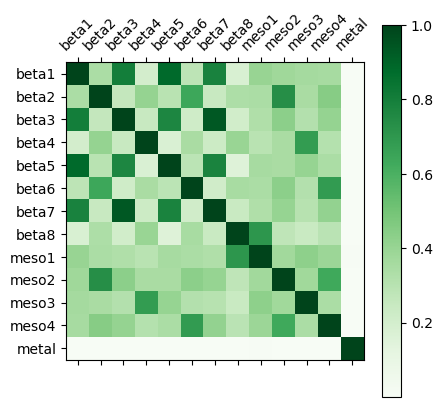

In [242]:
plt.matshow(por_distances_df.corr() ** 2, cmap="Greens");
plt.colorbar();
plt.xticks(range(len(por_distances_df.columns)), [c.split()[-1] for c in por_distances_df.columns], rotation=45);
plt.yticks(range(len(por_distances_df.columns)), [c.split()[-1] for c in por_distances_df.columns]);

/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


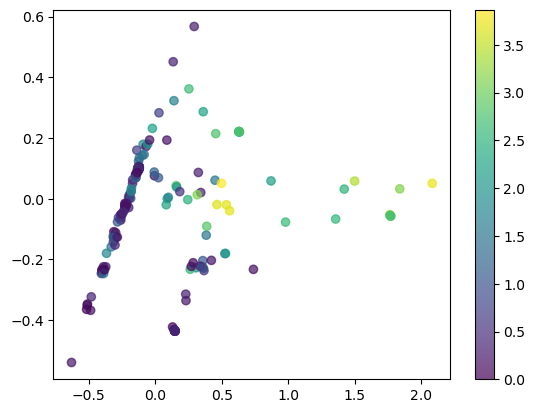

In [247]:
from sklearn.decomposition import PCA
model = PCA(n_components=2)
vecs = model.fit_transform(por_distances_df)
target = relative_np[relative_np.index.isin(por_sids)]["total"]
# target = absolute_np[absolute_np.index.isin(por_sids)]["doming"].abs()
plt.scatter(vecs[:, 0], vecs[:, 1], c=target, alpha=0.7);
plt.colorbar();

fitting models

In [263]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
# model = KernelRidge(alpha=0.001, kernel="rbf")
model = RandomForestRegressor(n_estimators=1000)
# kernel = 1 * RBF(length_scale=1e-5, length_scale_bounds=(1e-10, 1))
# kernel = Matern(length_scale=1e-3, nu=0.01)
# model = GaussianProcessRegressor(kernel, n_restarts_optimizer=9, normalize_y=True)
# por_distances_feat.normalize()
X = np.array(por_distances_df.values)
y = np.array(relative_np[relative_np.index.isin(por_sids)]["total"])
# y = np.array(absolute_np[absolute_np.index.isin(por_sids)]["saddling"].abs())
idxs = list(filter(lambda i: y[i] > 0.2, range(len(y))))
X = X[idxs]
y = y[idxs]
print("N =", len(X))
print("N parameters =", X.shape[1:])
# ymean = np.mean(y)
# ystd = np.std(y)
# y = (y - ymean) / ystd
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=42)
print("N train =", len(xtrain), "N test =", len(xtest))
model.fit(xtrain, ytrain);
# model.kernel_

N = 204
N parameters = (13,)
N train = 183 N test = 21


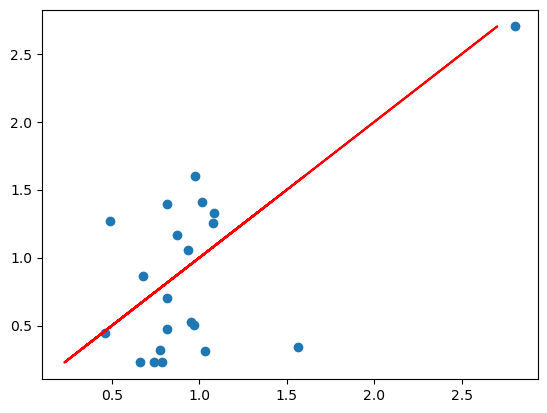

In [264]:
plt.scatter(model.predict(xtest), ytest);
plt.plot(ytest, ytest, "r");

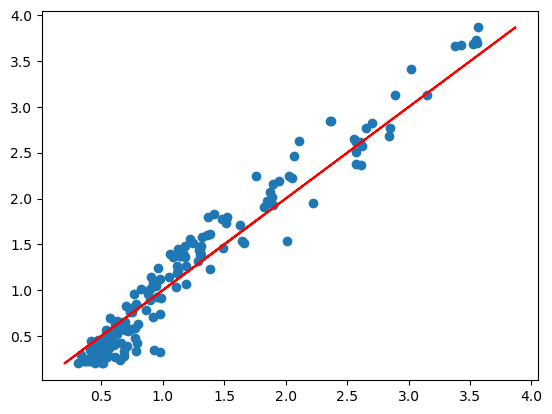

In [265]:
plt.scatter(model.predict(xtrain), ytrain);
plt.plot(ytrain, ytrain, "r");